# Perturbation modeling with the {class}`~moscot.problems.generic.SinkhornProblem`

In this tutorial, we showcase how to use the generic solver class :class:`~moscot.problems.generic.SinkhornProblem` to model cellular responses to chemical drugs.



## Preliminaries

In [1]:
import warnings

import moscot as mt
import moscot.plotting as mtp
from moscot.problems.generic import SinkhornProblem
from tqdm.std import TqdmWarning

import numpy as np

import matplotlib.pyplot as plt

import scanpy as sc

warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", TqdmWarning)
warnings.simplefilter("ignore", FutureWarning)

### Dataset description

The {func}`~moscot.datasets.sciplex` dataset is a perturbation dataset published in {cite}`srivatsan:20`.
It contains transcriptomes of A549, K562, and mCF7 cells exposed to 188 compounds.
Data obtained from [scPerturb](http://projects.sanderlab.org/scperturb/).

In [2]:
adata = mt.datasets.sciplex()
adata

AnnData object with n_obs × n_vars = 799317 × 110984
    obs: 'ncounts', 'well', 'plate', 'cell_line', 'replicate', 'time', 'dose_value', 'pathway_level_1', 'pathway_level_2', 'perturbation', 'target', 'pathway', 'dose_unit', 'celltype', 'disease', 'cancer', 'tissue_type', 'organism', 'perturbation_type', 'ngenes', 'percent_mito', 'percent_ribo', 'nperts', 'chembl-ID'
    var: 'ensembl_id', 'ncounts', 'ncells'

### Filter the data


In [3]:
drugs = [
    "Dacinostat (LAQ824)",
    "Flavopiridol HCl",
    "Givinostat (ITF2357)",
    "TAK-901",
]

In [4]:
adata_red = adata[adata.obs["perturbation"].isin(["control"] + drugs)].copy()
adata_red

AnnData object with n_obs × n_vars = 29020 × 110984
    obs: 'ncounts', 'well', 'plate', 'cell_line', 'replicate', 'time', 'dose_value', 'pathway_level_1', 'pathway_level_2', 'perturbation', 'target', 'pathway', 'dose_unit', 'celltype', 'disease', 'cancer', 'tissue_type', 'organism', 'perturbation_type', 'ngenes', 'percent_mito', 'percent_ribo', 'nperts', 'chembl-ID'
    var: 'ensembl_id', 'ncounts', 'ncells'

In [5]:
sc.pp.normalize_total(adata_red, target_sum=1e4)
sc.pp.log1p(adata_red)
sc.pp.pca(adata_red)
sc.pp.neighbors(adata_red)
sc.tl.umap(adata_red)

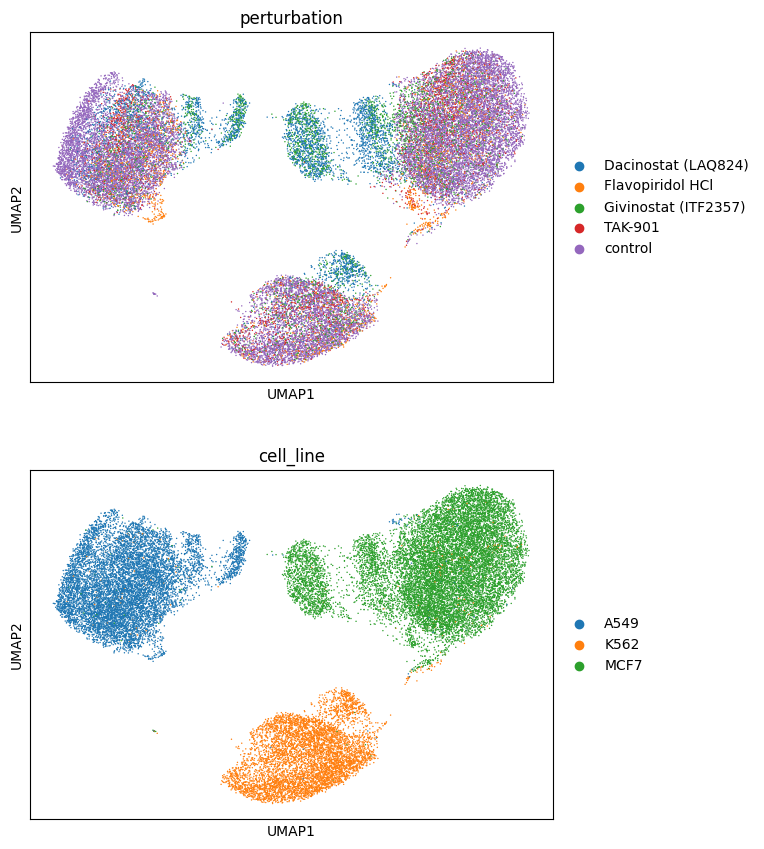

In [6]:
sc.pl.umap(adata_red, color=["perturbation", "cell_line"], ncols=1)

In this case, we want to compare the perturbations from the selected drugs with the control, so we use the star policy with the control as reference.

In [7]:
sp = SinkhornProblem(adata_red)
sp = sp.prepare(
    key="perturbation", joint_attr="X_pca", policy="star", reference="control"
)
sp = sp.solve(1e-2, 0.95, 0.95)
sp

INFO     Solving `4` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(3609, 17578)].                                         
INFO     Solving problem OTProblem[stage='prepared', shape=(3545, 17578)].                                         
INFO     Solving problem OTProblem[stage='prepared', shape=(2559, 17578)].                                         
INFO     Solving problem OTProblem[stage='prepared', shape=(1729, 17578)].                                         


SinkhornProblem[('Dacinostat (LAQ824)', 'control'), ('Givinostat (ITF2357)', 'control'), ('TAK-901', 'control'), ('Flavopiridol HCl', 'control')]

We can verify that the transport plan we learn is meaningful, as cell lines are mapped onto themselves.

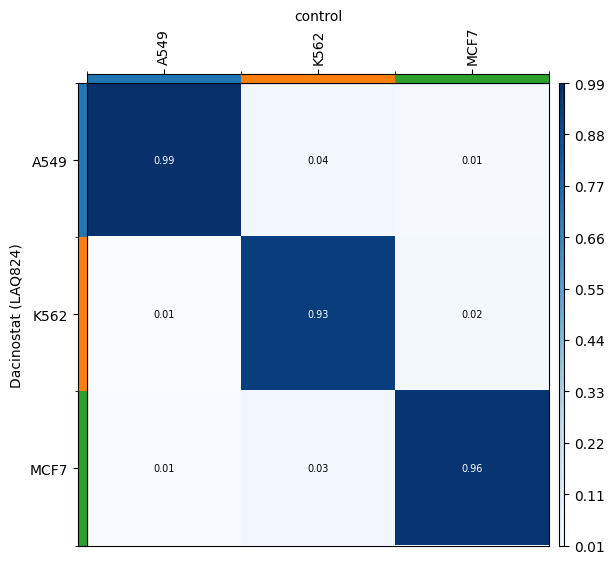

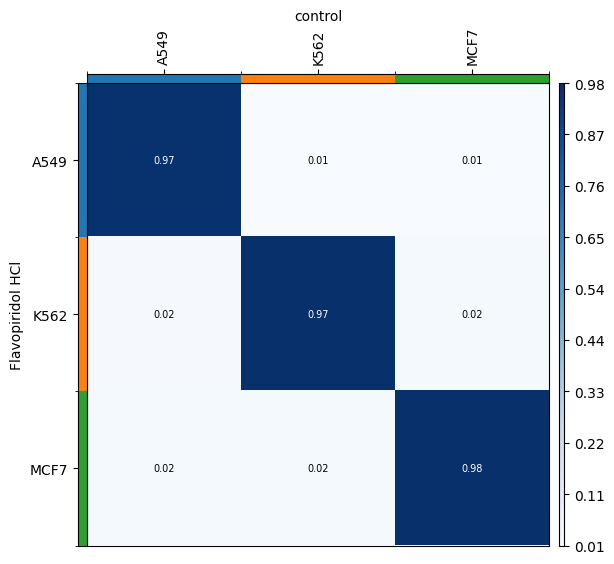

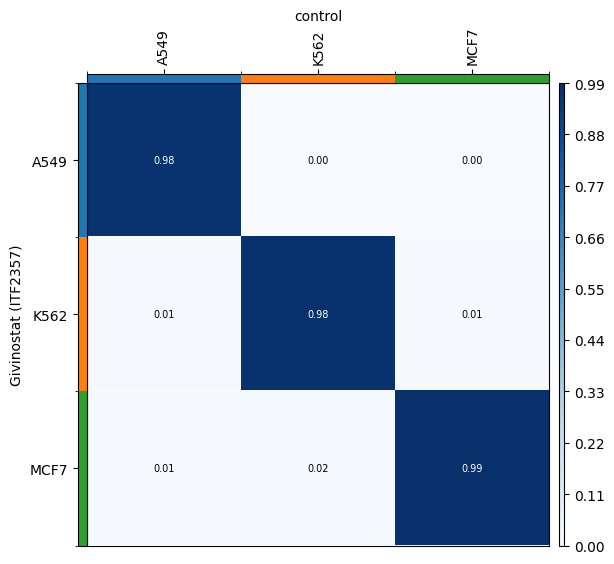

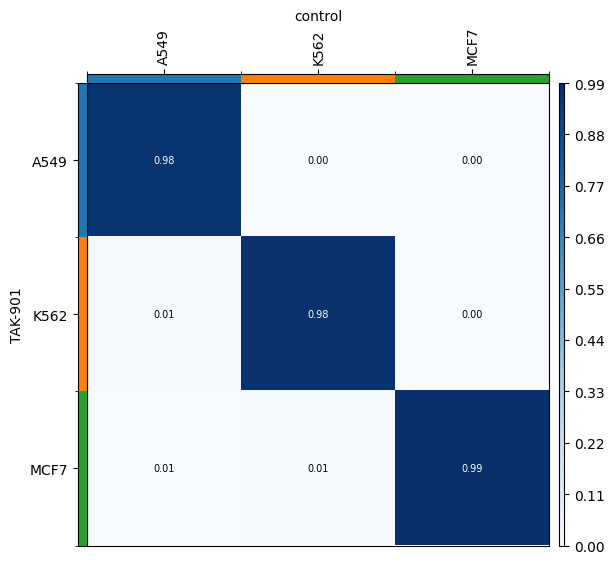

In [8]:
for drug in drugs:
    transition_matrix = sp.cell_transition(
        drug, "control", "cell_line", "cell_line", key_added=f"cell_transition_{drug}"
    )
    mtp.cell_transition(sp, key=f"cell_transition_{drug}", cmap="Blues")

In [9]:
sc.tl.leiden(adata_red, key_added="new_clusters", resolution=0.9)

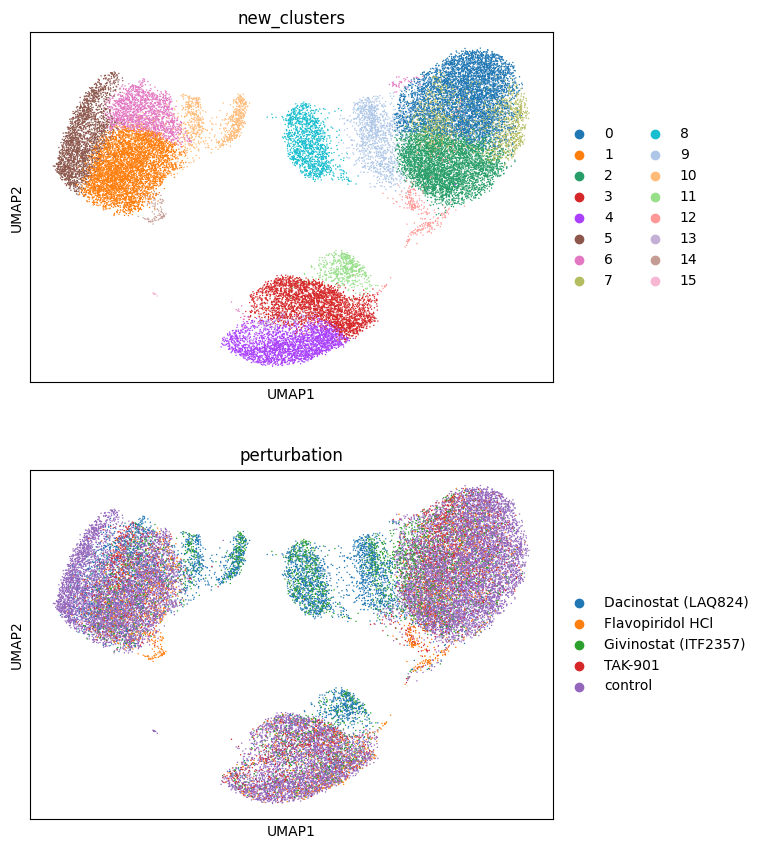

In [10]:
sc.pl.umap(adata_red, color=["new_clusters", "perturbation"], ncols=1)

We now choose cluster 11 and see where it comes from

In [11]:
for drug in drugs:
    sp.pull(
        source=drug,
        target="control",
        data="new_clusters",
        subset="11",
        key_added=f"pull_1_{drug}",
    )

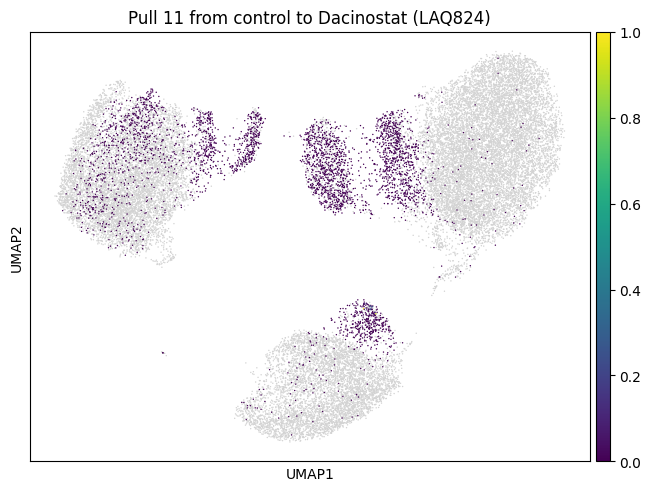

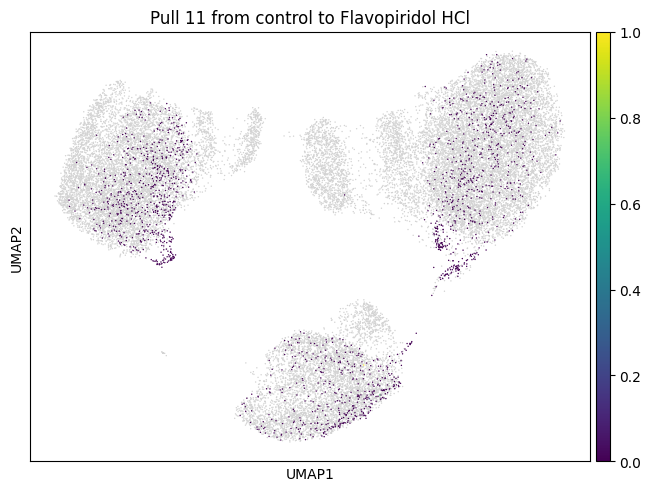

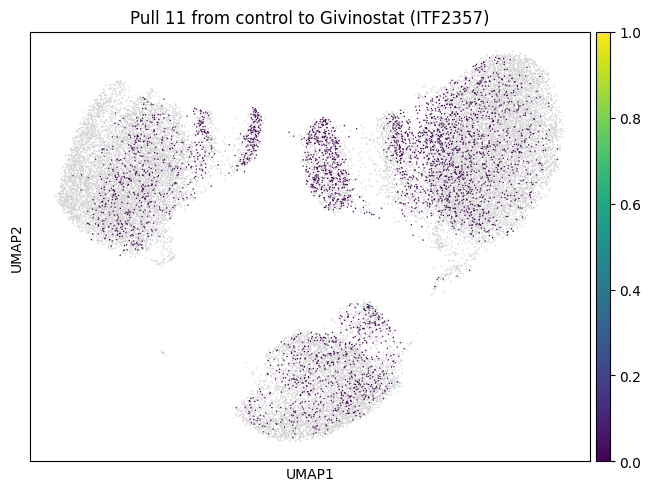

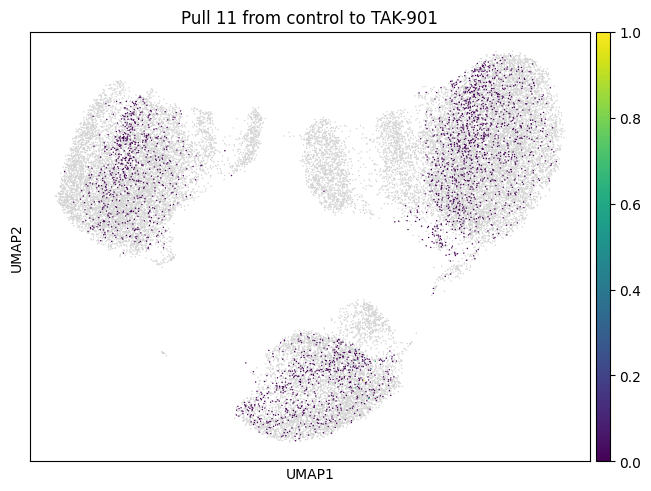

In [12]:
for drug in drugs:
    mtp.pull(sp, key=f"pull_1_{drug}")

Let's do the same for another cluster which is a bit bigger.

In [13]:
for drug in drugs:
    sp.pull(
        source=drug,
        target="control",
        data="new_clusters",
        subset="8",
        key_added=f"pull_2_{drug}",
    )

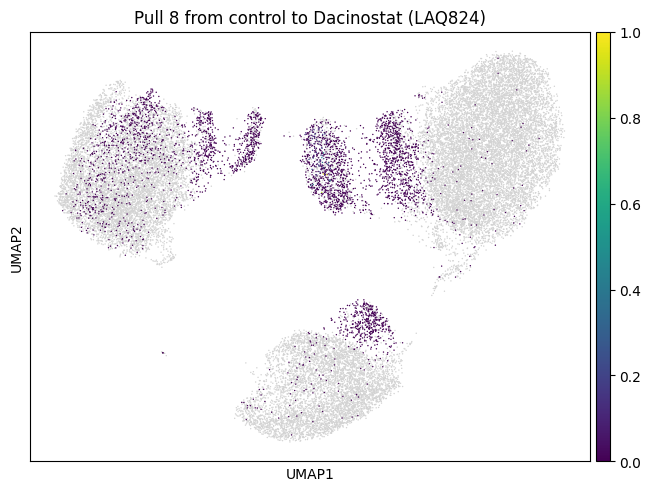

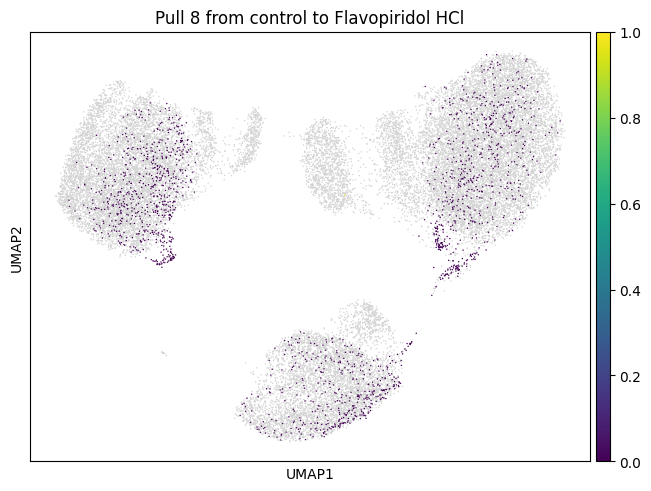

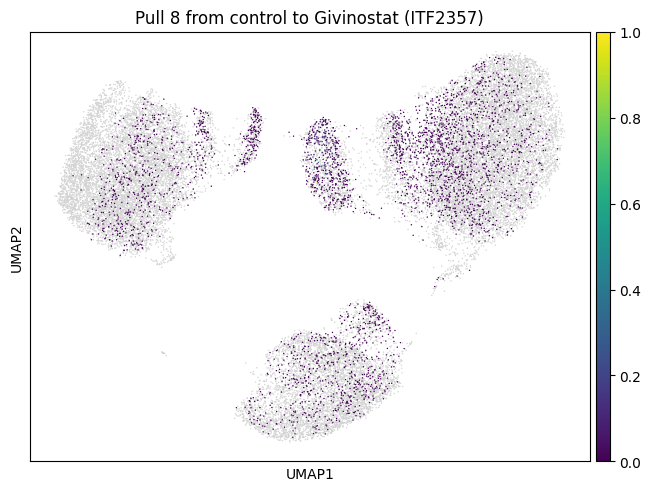

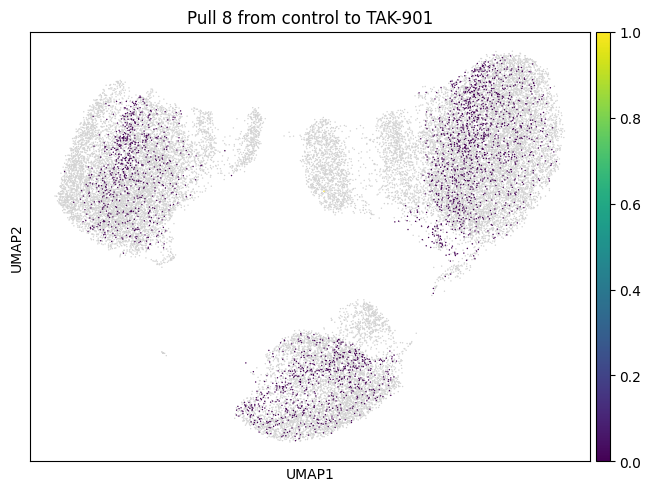

In [14]:
for drug in drugs:
    mtp.pull(sp, key=f"pull_2_{drug}")